In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time
import os
import sys
import json

import scipy as sp
from scipy import signal

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import os, warnings, random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, Sequential, Model
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
SEED = 13
tf.random.set_seed(SEED)

In [3]:
def encode_gait_percentage(df, name):
  percent = df[name].values.tolist()
  X = np.zeros((len(df[name]),1))
  Y = np.zeros((len(df[name]),1))
  for i in range (len(percent)):
    phi = percent[i] * 2 * math.pi / 100
    X[i] = math.cos(phi)
    Y[i] = math.sin(phi)
  df['X'] = X
  df['Y'] = Y

In [4]:
def convert_data(d_x, d_y, look_back = 1, fore_cast = 1):
    dataX = []
    dataY = []

    for i in range(look_back, len(d_x) - fore_cast):
        dataX.append(d_x[i - look_back: i])
        dataY.append(d_y[i + fore_cast,:])

    return np.array(dataX), np.array(dataY)

In [5]:
#from google.colab import drive

#rive.mount('/content/drive')
#path =path = '/content/drive/MyDrive/nmchr_lab/Subjects/inclined/new/right_based/'


In [6]:
working_dir = os.getcwd()#os.path.dirname(os.getcwd())
sys_platform = sys.platform
excel_path_dict = {'linux' : "/csvs/", 'win32' : "\Data\Incline\\right_based\SD\\"}
excel_path_name = excel_path_dict[sys_platform]

directory_path = working_dir 
print(directory_path)
excel_path = directory_path + excel_path_name


c:\Users\Admin\Desktop\Neurorobotic Lab\Data_Code\Model\Gait_Phase_Prediction


In [69]:
#inclined_files = ['SKS_2_I.xlsx',  'SKS_3_I.xlsx',  'SKS_4_I.xlsx','SKS_5_I.xlsx', 'SD_2_I.xlsx',  'SD_3_I.xlsx',  'SD_4_I.xlsx','SD_5_I.xlsx']

# Subj TH:
#file_name = ['TH_4_I_r.xlsx', 'TH_2_I_r.xlsx', 'TH_3_I_r.xlsx']

# Subj JJ:
#file_name = ['JJ_4_I.xlsx', 'JJ_6_I.xlsx', 'JJ_7_I.xlsx']
#file_name = ['JJ_4_I_r.xlsx', 'JJ_6_I_r.xlsx', 'JJ_7_I_r.xlsx']

# Subj SD:
file_name = ['SD_1_I_r.xls', 'SD_4_I_r.xls', 'SD_2_I_r.xls', 'SD_3_I_r.xls', 'SD_5_I_r.xls']

# Subj PK:
#file_name = ['PK_0_I_r.xls', 'PK_5_I_r.xls', 'PK_2_I_r.xls', 'PK_3_I_r.xls']

# Subj SKS:
#file_name = ['SKS_0_I_r.xls', 'SKS_4_I_r.xls', 'SKS_2_I_r.xls', 'SKS_3_I_r.xls', 'SKS_5_I_r.xls']

file_list=[]

for i in range (len(file_name)):
    file_list.append(pd.read_excel(excel_path + file_name[i], sheet_name='Sheet1'))

import random
random.shuffle(file_list)

all_data = pd.concat(file_list, axis=0, ignore_index=True)


In [70]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217324 entries, 0 to 217323
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   l_ph_hip      217324 non-null  float64
 1   l_ph_ank      217324 non-null  float64
 2   l_ph_fo       217324 non-null  float64
 3   r_ph_hip      217324 non-null  float64
 4   r_ph_ank      217324 non-null  float64
 5   r_ph_fo       217324 non-null  float64
 6   n_lgrf        217324 non-null  float64
 7   n_r_grf       217324 non-null  float64
 8   n_lcop        217324 non-null  float64
 9   n_rcop        217324 non-null  float64
 10  perc_new      217324 non-null  float64
 11  st_sw_phase   217324 non-null  int64  
 12  strike_frame  217324 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 21.6 MB


In [71]:
cycle = 0
cycle_list = []

start = 0

for i in range(len(all_data) - 1):
    if (all_data['perc_new'][i+1] == 0):
        cycle += 1
        cycle_list.append(all_data.iloc[start:i])
        start = i+1

random.shuffle(cycle_list)
source_table = pd.concat(cycle_list, axis=0, ignore_index=True)

source_table


,l_ph_hip,l_ph_ank,l_ph_fo,r_ph_hip,r_ph_ank,r_ph_fo,n_lgrf,n_r_grf,n_lcop,n_rcop,perc_new,st_sw_phase,strike_frame
0,0.641317,0.666941,0.153010,0.958910,0.866357,0.753892,0.671650,0.039560,0.091556,-0.000039,0.000000,0,1
1,0.623911,0.658566,0.110126,0.957734,0.846948,0.751823,0.670171,0.057615,0.092713,-0.000004,0.487805,0,2
2,0.599884,0.649852,0.033764,0.956194,0.832833,0.749830,0.666836,0.078883,0.093802,0.000040,0.975610,1,3
3,0.566736,0.640870,0.938698,0.954287,0.822264,0.747866,0.661449,0.102954,0.094773,0.000095,1.463415,1,4
4,0.523148,0.631703,0.870875,0.952015,0.814131,0.745887,0.653827,0.129321,0.095577,0.000159,1.951220,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
216121,0.693447,0.662444,0.225256,0.946989,0.098375,0.721298,0.679879,0.000000,0.080746,-0.000583,97.413793,0,227
216122,0.690859,0.673246,0.223058,0.946728,0.055541,0.721455,0.681533,0.000000,0.082113,-0.000605,97.844828,0,228
216123,0.687785,0.682417,0.220548,0.946697,0.004995,0.721266,0.682831,0.000000,0.083525,-0.000617,98.275862,0,229
216124,0.684092,0.690156,0.217636,0.946853,0.955442,0.720760,0.683665,0.015011,0.084984,-0.000614,98.706897,0,230


In [72]:
source_table = source_table.drop(["n_lgrf","n_r_grf","l_ph_ank","r_ph_ank", "l_ph_hip", "r_ph_hip"], axis = 1)
source_table

,l_ph_fo,r_ph_fo,n_lcop,n_rcop,perc_new,st_sw_phase,strike_frame
0,0.153010,0.753892,0.091556,-0.000039,0.000000,0,1
1,0.110126,0.751823,0.092713,-0.000004,0.487805,0,2
2,0.033764,0.749830,0.093802,0.000040,0.975610,1,3
3,0.938698,0.747866,0.094773,0.000095,1.463415,1,4
4,0.870875,0.745887,0.095577,0.000159,1.951220,1,5
...,...,...,...,...,...,...,...
216121,0.225256,0.721298,0.080746,-0.000583,97.413793,0,227
216122,0.223058,0.721455,0.082113,-0.000605,97.844828,0,228
216123,0.220548,0.721266,0.083525,-0.000617,98.275862,0,229
216124,0.217636,0.720760,0.084984,-0.000614,98.706897,0,230


In [73]:
x = source_table
x = x.drop(['perc_new'], axis=1)
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)

encode_gait_percentage(source_table, 'perc_new')
y = source_table[["X","Y"]]
y

data_x = x_scaled


In [74]:
data_y = y.values.reshape(-1,2)

In [75]:
type(data_y)

numpy.ndarray

In [76]:

#data_x,data_y= shuffle_multiple_datasets_based_on_gait_cycle( file_name, excel_path)

X_train, X_test,y_train, y_test = train_test_split(data_x, data_y ,
                        test_size=0.25,
                        shuffle=False)
look_back = 10
fore_cast = 1

train_x, train_y = convert_data(X_train, y_train, look_back, fore_cast)
validation_x, validation_y = convert_data(X_test, y_test, look_back, fore_cast)


In [77]:
print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)


(162083, 10, 6)
(162083, 2)
(54021, 10, 6)
(54021, 2)


In [78]:
train_x.shape

(162083, 10, 6)

In [79]:
n1=validation_x.shape[0]
val_x=validation_x[1:int(n1/10),:]
val_y=validation_y[1:int(n1/10),:]
print(val_x.shape)
print(val_y.shape)

(5401, 10, 6)
(5401, 2)


In [80]:
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [81]:

lr = 0.001
epochs = 30
batch = 128

x=Input(shape=(10, train_x.shape[2]))
n_features=train_x.shape[2]
# RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
LSTM_layer1 = LSTM(64, return_sequences=True)(x)
LSTM_layer2 = LSTM(32, return_sequences=True)(LSTM_layer1)
attn_layer1 = attention()(LSTM_layer2)
rep_layer = L.RepeatVector((10))(attn_layer1)
# attn_layer2 = attention()(rep_layer)
LSTM_layer3 = LSTM(32, return_sequences=True)(rep_layer)
LSTM_layer4 = LSTM(64, return_sequences=True)(LSTM_layer3)
lin_layer = L.TimeDistributed(L.Dense(n_features))(LSTM_layer4)
# tmp_layer = Flatten()(rep_layer)
# lin_layer = L.Dense(2)(tmp_layer)
model=Model(x,lin_layer)
model.summary()
adam = optimizers.Adam(lr)
model.compile(loss='mse', optimizer=adam)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 6)]           0         
                                                                 
 lstm_8 (LSTM)               (None, 10, 64)            18176     
                                                                 
 lstm_9 (LSTM)               (None, 10, 32)            12416     
                                                                 
 attention_2 (attention)     (None, 32)                42        
                                                                 
 repeat_vector_2 (RepeatVect  (None, 10, 32)           0         
 or)                                                             
                                                                 
 lstm_10 (LSTM)              (None, 10, 32)            8320      
                                                           

In [82]:
model_history = model.fit( train_x, train_x, epochs=epochs, batch_size=batch,  verbose=1)

Epoch 1/30
1267/1267 [==============================] - 35s 24ms/step - loss: 0.0102
Epoch 2/30
1267/1267 [==============================] - 31s 25ms/step - loss: 0.0024
Epoch 3/30
1267/1267 [==============================] - 60s 48ms/step - loss: 0.0017
Epoch 4/30
1267/1267 [==============================] - 63s 50ms/step - loss: 0.0013
Epoch 5/30
1267/1267 [==============================] - 66s 52ms/step - loss: 0.0010
Epoch 6/30
1267/1267 [==============================] - 45s 35ms/step - loss: 8.2886e-04
Epoch 7/30
1267/1267 [==============================] - 35s 27ms/step - loss: 6.7908e-04
Epoch 8/30
1267/1267 [==============================] - 33s 26ms/step - loss: 5.7383e-04
Epoch 9/30
1267/1267 [==============================] - 33s 26ms/step - loss: 4.8800e-04
Epoch 10/30
1267/1267 [==============================] - 33s 26ms/step - loss: 4.1274e-04
Epoch 11/30
1267/1267 [==============================] - 34s 27ms/step - loss: 3.9252e-04
Epoch 12/30
1267/1267 [================

In [83]:
encoder = Model(inputs=model.inputs, outputs=model.layers[3].output)
train_encoded = encoder.predict(train_x)
validation_encoded = encoder.predict(validation_x)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

1689/1689 [==============================] - 6s 3ms/step
Encoded time-series shape (162083, 32)
Encoded time-series sample [ 0.39099365 -0.17283279  0.27608448 -0.6405616  -0.36417913 -0.87117875
  0.36937332 -0.15135694  0.16506281 -0.5600277   0.04398792 -0.36531413
  0.67733    -0.7624607   0.4751253  -0.54853445  0.8534491   0.6290537
  0.08917607  0.07693354  0.09243859 -0.35729986  0.11280491 -0.85886097
 -0.20172733 -0.49410558  0.78733     0.4305156  -0.4251297  -0.69181085
  0.36300087 -0.84932756]


In [84]:
#model.save(path+"autoen_new_model")

In [85]:
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.005
	epochs_drop = 10
	lrate=initial_lrate - 0.00001
	# lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate


In [86]:
mlp_model = Sequential()
mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1])))
# mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1])))

mlp_model.add(L.Dense(8, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(L.Dense(2))
mlp_model.summary()

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
adam = optimizers.Adam(lr_schedule)

mlp_model.compile(loss='mse', optimizer=adam)
lrate = LearningRateScheduler(step_decay)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 8)                 264       
                                                                 
 dense_11 (Dense)            (None, 2)                 18        
                                                                 
Total params: 1,338
Trainable params: 1,338
Non-trainable params: 0
_________________________________________________________________


In [87]:
epochs = 50
# lrate = LearningRateScheduler(step_decay)
monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=3, verbose=1, mode='auto')
# train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]*train_encoded.shape[2]))

# train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]))
train_encoded_reshaped = train_encoded
callback_list = [monitor]
mlp_history = mlp_model.fit(train_encoded_reshaped , train_y, callbacks=callback_list, epochs=epochs, batch_size=batch,  verbose=2)

Epoch 1/50
1267/1267 - 1s - loss: 0.0372 - 1s/epoch - 1ms/step
Epoch 2/50
1267/1267 - 1s - loss: 0.0081 - 1s/epoch - 897us/step
Epoch 3/50
1267/1267 - 1s - loss: 0.0069 - 1s/epoch - 886us/step
Epoch 4/50
1267/1267 - 1s - loss: 0.0063 - 1s/epoch - 912us/step
Epoch 5/50
1267/1267 - 1s - loss: 0.0059 - 1s/epoch - 902us/step
Epoch 6/50
1267/1267 - 1s - loss: 0.0057 - 1s/epoch - 909us/step
Epoch 7/50
1267/1267 - 1s - loss: 0.0055 - 1s/epoch - 885us/step
Epoch 8/50
1267/1267 - 1s - loss: 0.0053 - 1s/epoch - 916us/step
Epoch 9/50
1267/1267 - 1s - loss: 0.0052 - 1s/epoch - 891us/step
Epoch 10/50
1267/1267 - 1s - loss: 0.0050 - 1s/epoch - 915us/step
Epoch 11/50
1267/1267 - 1s - loss: 0.0049 - 1s/epoch - 891us/step
Epoch 12/50
1267/1267 - 1s - loss: 0.0048 - 1s/epoch - 901us/step
Epoch 13/50
1267/1267 - 1s - loss: 0.0047 - 1s/epoch - 952us/step
Epoch 14/50
1267/1267 - 1s - loss: 0.0046 - 1s/epoch - 908us/step
Epoch 15/50
1267/1267 - 1s - loss: 0.0045 - 1s/epoch - 838us/step
Epoch 16/50
1267/1267

In [88]:
val_encoded_reshaped = validation_encoded
trainPredict = mlp_model.predict(train_encoded_reshaped)
testPredict = mlp_model.predict(val_encoded_reshaped)

1689/1689 [==============================] - 2s 924us/step


In [89]:
testPredict.shape

(54021, 2)

In [90]:
from sklearn.metrics import mean_squared_error

trainScore = np.sqrt(mean_squared_error(train_y, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(validation_y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.06 RMSE
Test Score: 0.06 RMSE


In [91]:
v = X_test[11:]
v.shape

(54021, 6)

In [92]:

x_test = scaler.inverse_transform(v)

pred = np.zeros((len(testPredict),1))

for iter in range(len(testPredict)):
  x = testPredict[iter][0]
  y = testPredict[iter][1]
  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


  if ((pred[iter] >= 80) & (x_test[iter][-1] <= 20)) :
    pred[iter] = pred[iter] - 100
    
    if abs(pred[iter]) >= 5:
        pred[iter] = 0


  if ((pred[iter] <= 20) & (x_test[iter][-1] >= 150)):
     pred[iter] = 100 - pred[iter]
     if abs(pred[iter]) >= 5:
         pred[iter] = 100




  #if (pred[iter] > 100):
  #  pred[iter] = pred[iter] - 100

pred1=pd.DataFrame(pred).sort_index().reset_index()

In [93]:
actual = np.zeros((len(validation_y),1))

for iter in range(len(validation_y)):
  x =validation_y[iter][0]
  y =validation_y[iter][1]
  actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

In [94]:
correct = 0
for i in range(5):
  correct = 0
  for iter in range(len(actual)):
    #if (abs(actual[iter] - pred[iter]) <= (i+1)) or (actual[iter]>98) or(actual[iter]<3):
      #correct+=1
      if (abs(actual[iter] - pred[iter]) <= (i+1)):
        correct+=1

  print(correct)
  print(len(actual))

  print("Precision ", i+1, ": ", correct * 100/len(actual))

35504
54021
Precision  1 :  65.72258936339571
48281
54021
Precision  2 :  89.37450250828381
52033
54021
Precision  3 :  96.31994964921049
53269
54021
Precision  4 :  98.60794876066714
53656
54021
Precision  5 :  99.32433683197276


In [95]:
perc_rmse = np.sqrt(mean_squared_error(actual, pred))
print("Predicting Percentage RMSE: ", perc_rmse)



Predicting Percentage RMSE:  1.3266413968133188


In [96]:
rmse = 0
length = len(actual)
for i in range(len(actual)):

    rmse = rmse + pow(pred[i] - actual[i], 2)
rmse = rmse / length
rmse = math.sqrt(rmse)
print(length)
print(len(actual))
print(rmse)

54021
54021
1.3266413968133137


35830
54021


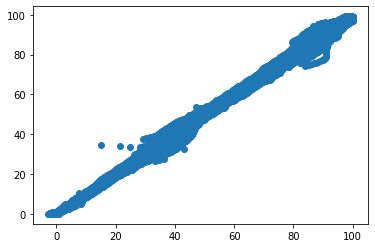

In [97]:
correct = 0

plt.figure()
plt.scatter(pred, actual)
for iter in range(len(actual)):
  if actual[iter]<2 or actual[iter]>98:
    correct+=1
    continue
  if (abs(actual[iter] - pred[iter]) <= 1):
    correct+=1


print(correct)
print(len(actual))

Text(0.5, 1.0, 'Actual vs Prediction')

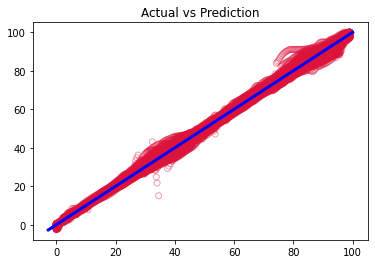

In [98]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

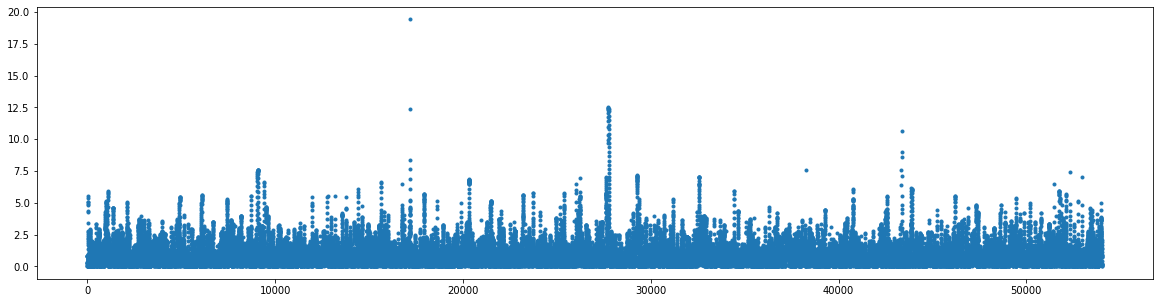

In [99]:
predfig=plt.figure(figsize=(20,5))
dif = abs(actual-pred)

plt.plot(dif,'.')